In [50]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import collections
import scipy
from scipy import stats
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu
import matplotlib as mpl

from scipy.cluster.hierarchy import linkage, is_valid_linkage
from scipy.spatial.distance import pdist

from scipy.cluster.hierarchy import fcluster

from sklearn.decomposition import NMF

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from bioinfokit.visuz import cluster
from sklearn.cluster import DBSCAN

In [51]:
cp_ip={'constitutive proteosome': '#bf812d','Immuno proteosome':'#35978f'}

In [52]:
commonFontsize=8
def config_rcparams():
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = commonFontsize
    plt.rcParams['axes.labelsize'] = commonFontsize
    plt.rcParams['xtick.labelsize'] = commonFontsize
    plt.rcParams['ytick.labelsize'] = commonFontsize
    plt.rcParams['axes.titlesize'] = commonFontsize
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.linewidth'] = 0.7
    plt.rcParams['xtick.major.width'] = 0.7
    plt.rcParams['ytick.major.width'] = 0.7
    plt.rcParams['xtick.major.size' ] = 3
    plt.rcParams['ytick.major.size' ] = 3
    plt.rcParams['text.usetex' ] = False
config_rcparams()

## Collect all the probes for the methylation

In [53]:
import glob, os
os.chdir("/workspace/shared/dataset/tcga_exome/methylation/correlation_methylation_vs_mRNA/")
methylation_tumor_corr=[]
for  i in glob.glob("*.txt"):
    methylation_tumor_corr.append(i)
os.chdir("/workspace/projects/immunoproteasome/")

In [54]:
### Importing methylation beta value
input_path2="/workspace/projects/immunoproteasome/"
meth_df_beta_value=pd.read_csv(input_path2+"jhu-usc.edu_PANCAN_merged_HumanMethylation27_HumanMethylation450.betaValue_whitelisted.tsv",sep="\t")
meth_df_beta_value.columns= meth_df_beta_value.columns.str.split('-').str[0:3].str.join('.')
meth_df_beta_value1=meth_df_beta_value.set_index('Composite Element REF')
meth_df_beta_value2=meth_df_beta_value1.T

In [55]:
### Importing copy number file
copy_no_df=pd.read_csv("/workspace/shared/dataset/tcga_exome/CNA/all_thresholded.by_genes_whitelisted.tsv",index_col='Gene Symbol',sep="\t")
copy_no_df=copy_no_df.drop(['Locus ID','Cytoband'],axis=1)
copy_no_df.columns= copy_no_df.columns.str.split('-').str[0:3].str.join('.')
copy_no_df2=copy_no_df.T[['PSMB8','PSMB9','PSMB10']]

In [56]:
copy_no_meth_df=pd.merge(copy_no_df2, meth_df_beta_value2, left_index=True, right_index=True)

In [57]:
## Collecting genes probe combination intersecting the probes in the methylation correaltion file with the methylation beta value file
input_path1="/workspace/shared/dataset/tcga_exome/methylation/correlation_methylation_vs_mRNA/"
meth_beta_value_probe_list=list(meth_df_beta_value2.columns)
meth_probe_list=[]
frames={}
frames1={}
gene_probes=['PSMB8','PSMB9','PSMB10']
for j in range(3):
    meth_probe_list=[]
    tissue_type=[]
    for i in range(len(methylation_tumor_corr)):
        meth_df = pd.read_csv(input_path1+methylation_tumor_corr[i],delimiter="\t")
        meth_probe_list.append(list(meth_df[meth_df['Gene']==gene_probes[j]]['Meth_Probe']))
        tissue_type.append(methylation_tumor_corr[i].split('_')[4].split('-')[0])
        
    df_tissue_probe=pd.DataFrame(meth_probe_list,columns=['probe'])
    df_tissue_probe['tumor_type']=tissue_type
    df_tissue_probe['genes']=gene_probes[j]
    frames1[j]=df_tissue_probe                

    meth_probe_list_all=list(set(sum(meth_probe_list,[])))
    all_beta_value_int_list=list(set(meth_beta_value_probe_list).intersection(meth_probe_list_all))
    
    df_probe_gene=pd.DataFrame()
    df_probe_gene['probes']=all_beta_value_int_list
    df_probe_gene['genes']=gene_probes[j]
    frames[j]=df_probe_gene

## extracting tumor type specific probe
probe_gene_df=pd.concat(frames)
df_probe_tt_genes=pd.concat(frames1)
df_probe_tt_genes_final=df_probe_tt_genes[df_probe_tt_genes['probe'].isin(list(probe_gene_df['probes']))]

In [58]:
df_probe_tt_genes_final

probe tumor_type   genes
1 17  cg12762680        GBM   PSMB9
  29  cg12762680         OV   PSMB9
2 2   cg11451801       TGCT  PSMB10
  6   cg11451801       THCA  PSMB10
  17  cg11451801        GBM  PSMB10
  22  cg11451801       KIRC  PSMB10
  29  cg11451801         OV  PSMB10

/home/rahul/miniconda3/envs/testenv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

none v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=2.350e-53 U_stat=1.295e+07
deleted v.s. amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=4.668e-45 U_stat=1.841e+06
none v.s. amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=9.108e-04 U_stat=5.218e+06


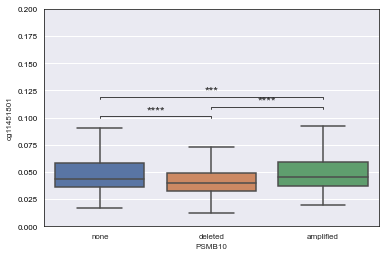

/home/rahul/miniconda3/envs/testenv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

none v.s. amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=3.333e-52 U_stat=1.093e+07
amplified v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=1.757e-103 U_stat=1.023e+06
none v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=5.608e-55 U_stat=4.432e+06


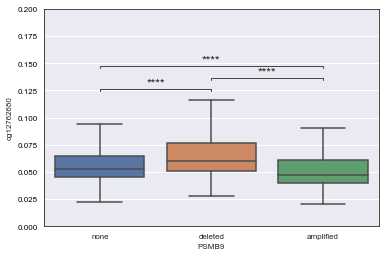

In [85]:
#sns.set(font_scale=1)
order=['none','deleted','amplified']
box_pairs=[('none','deleted'),('none','amplified'),('deleted','amplified')]
dft=copy_no_meth_df[['PSMB10','cg11451801']]
#dft['cg11451801']=np.log2(dft['cg11451801']+1)
dft.loc[dft["PSMB10"] == 0,'PSMB10'] = 'none'
dft.loc[dft["PSMB10"] == 1,'PSMB10'] = 'amplified'
dft.loc[dft["PSMB10"] == 2,'PSMB10'] = 'amplified'
dft.loc[dft["PSMB10"] == -1,'PSMB10'] = 'deleted'
dft.loc[dft["PSMB10"] == -2,'PSMB10'] = 'deleted'
res=sns.boxplot(x="PSMB10", y="cg11451801",data=dft,showfliers=False,order=order)
add_stat_annotation(res, data=dft, x="PSMB10", y="cg11451801",box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None,text_format='star', loc='outside', verbose=2,linewidth=0.9,fontsize = 12)
res.set(ylim=(0, 0.2))
plt.savefig('/workspace/projects/immunoproteasome/plots/PSMB10_meth_probe_plot.svg',bbox_inches = "tight",dpi=500)
plt.show()

dft=copy_no_meth_df[['PSMB9','cg12762680']]
#dft['cg12762680']=np.log2(dft['cg12762680']+1)
dft.loc[dft["PSMB9"] == 0,'PSMB9'] = 'none'
dft.loc[dft["PSMB9"] == 1,'PSMB9'] = 'amplified'
dft.loc[dft["PSMB9"] == 2,'PSMB9'] = 'amplified'
dft.loc[dft["PSMB9"] == -1,'PSMB9'] = 'deleted'
dft.loc[dft["PSMB9"] == -2,'PSMB9'] = 'deleted'
res=sns.boxplot(x="PSMB9", y="cg12762680",data=dft,showfliers=False,order=order)
add_stat_annotation(res, data=dft, x="PSMB9", y="cg12762680",box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None,text_format='star', loc='outside', verbose=2,linewidth=0.9,fontsize = 12)
res.set(ylim=(0, 0.2))
plt.savefig('/workspace/projects/immunoproteasome/plots/PSMB9_meth_probe_plot.svg',bbox_inches = "tight",dpi=500)
plt.show()


### IL6-JAK STAT pathways analysis

In [75]:
import glob, os
os.chdir("/workspace/projects/immunoproteasome/v1_copy_5/03_output/")
tumor_tissue_pathway_score=[]
for  i in glob.glob("GSVA*.tsv"):
    tumor_tissue_pathway_score.append(i)
os.chdir("/workspace/projects/immunoproteasome/")

In [76]:
tt_list=list(df_probe_tt_genes_final['tumor_type'])
gene_list=list(df_probe_tt_genes_final['genes'])
probe_list=list(df_probe_tt_genes_final['probe'])

input_path11="/workspace/projects/immunoproteasome/v1_copy_5/03_output/"
frames_jak_stat={}
for i in range(len(tumor_tissue_pathway_score)):
    pathway_score_df=pd.read_csv(input_path11+tumor_tissue_pathway_score[i],sep='\t')
    jak_stat_pathway_score_df=pathway_score_df.T[['HALLMARK_IL6_JAK_STAT3_SIGNALING']]
    jak_stat_pathway_score_df=jak_stat_pathway_score_df.reset_index(level=0)
    frames_jak_stat[i]=jak_stat_pathway_score_df
df_jak_stat=pd.concat(frames_jak_stat)
df_jak_stat=df_jak_stat.set_index(['index'])

copy_no_meth_jak_stat_gene_df=pd.merge(copy_no_meth_df, df_jak_stat, left_index=True, right_index=True)

/home/rahul/miniconda3/envs/testenv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

none v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=6.075e-03 U_stat=8.527e+06
deleted v.s. amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=1.387e-02 U_stat=2.047e+06
none v.s. amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=1.277e-06 U_stat=4.800e+06


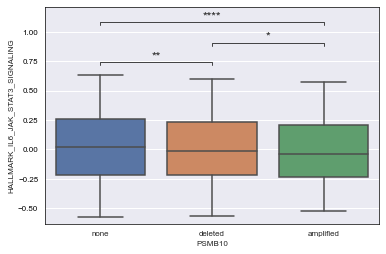

/home/rahul/miniconda3/envs/testenv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

none v.s. amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=6.317e-07 U_stat=7.397e+06
amplified v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=2.083e-01 U_stat=1.390e+06
none v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=5.449e-09 U_stat=5.150e+06


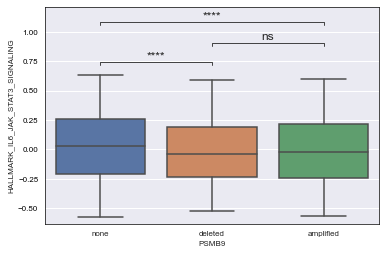

In [86]:
#sns.set(font_scale=1)
order=['none','deleted','amplified']
dft=copy_no_meth_jak_stat_gene_df[['PSMB10','HALLMARK_IL6_JAK_STAT3_SIGNALING']]
dft.loc[dft["PSMB10"] == 0,'PSMB10'] = 'none'
dft.loc[dft["PSMB10"] == 1,'PSMB10'] = 'amplified'
dft.loc[dft["PSMB10"] == 2,'PSMB10'] = 'amplified'
dft.loc[dft["PSMB10"] == -1,'PSMB10'] = 'deleted'
dft.loc[dft["PSMB10"] == -2,'PSMB10'] = 'deleted'
res=sns.boxplot(x="PSMB10", y="HALLMARK_IL6_JAK_STAT3_SIGNALING",data=dft,order=order)
add_stat_annotation(res, data=dft, x="PSMB10", y="HALLMARK_IL6_JAK_STAT3_SIGNALING",box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None,text_format='star', loc='inside', verbose=2,linewidth=0.9,fontsize = 12)
plt.savefig('/workspace/projects/immunoproteasome/plots/PSMB10_IL6_JAK_plot.svg',bbox_inches = "tight",dpi=500)
plt.show()

dft=copy_no_meth_jak_stat_gene_df[['PSMB9','HALLMARK_IL6_JAK_STAT3_SIGNALING']]
dft.loc[dft["PSMB9"] == 0,'PSMB9'] = 'none'
dft.loc[dft["PSMB9"] == 1,'PSMB9'] = 'amplified'
dft.loc[dft["PSMB9"] == 2,'PSMB9'] = 'amplified'
dft.loc[dft["PSMB9"] == -1,'PSMB9'] = 'deleted'
dft.loc[dft["PSMB9"] == -2,'PSMB9'] = 'deleted'
res=sns.boxplot(x="PSMB9", y="HALLMARK_IL6_JAK_STAT3_SIGNALING",data=dft,order=order)
add_stat_annotation(res, data=dft, x="PSMB9", y="HALLMARK_IL6_JAK_STAT3_SIGNALING",box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None,text_format='star', loc='inside', verbose=2,linewidth=0.9,fontsize = 12)
plt.savefig('/workspace/projects/immunoproteasome/plots/PSMB9_IL6_JAK_plot.svg',bbox_inches = "tight",dpi=500)
plt.show()

## Interferon-alpha analysis

In [88]:
import glob, os
os.chdir("/workspace/projects/immunoproteasome/v1_copy_5/03_output/")
tumor_tissue_pathway_score=[]
for  i in glob.glob("GSVA*.tsv"):
    tumor_tissue_pathway_score.append(i)
os.chdir("/workspace/projects/immunoproteasome/")

In [89]:
tt_list=list(df_probe_tt_genes_final['tumor_type'])
gene_list=list(df_probe_tt_genes_final['genes'])
probe_list=list(df_probe_tt_genes_final['probe'])

input_path11="/workspace/projects/immunoproteasome/v1_copy_5/03_output/"
frames_jak_stat={}
for i in range(len(tumor_tissue_pathway_score)):
    pathway_score_df=pd.read_csv(input_path11+tumor_tissue_pathway_score[i],sep='\t')
    jak_stat_pathway_score_df=pathway_score_df.T[['HALLMARK_INTERFERON_ALPHA_RESPONSE']]
    jak_stat_pathway_score_df=jak_stat_pathway_score_df.reset_index(level=0)
    frames_jak_stat[i]=jak_stat_pathway_score_df
    #meth_score_df=copy_no_meth_df[[probe_list[i]]]
    #jak_stat_meth_score_df=pd.merge(jak_stat_pathway_score_df, meth_score_df, left_index=True, right_index=True)
    #plt.plot(jak_stat_meth_score_df['HALLMARK_IL6_JAK_STAT3_SIGNALING'],jak_stat_meth_score_df[probe_list[i]],'o')
    #plt.title(tt_list[i]+'_'+gene_list[i])
    #plt.show()
df_jak_stat=pd.concat(frames_jak_stat)
df_jak_stat=df_jak_stat.set_index(['index'])

copy_no_meth_jak_stat_gene_df=pd.merge(copy_no_meth_df, df_jak_stat, left_index=True, right_index=True)

/home/rahul/miniconda3/envs/testenv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

none v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=1.355e-03 U_stat=8.578e+06
deleted v.s. amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=4.024e-02 U_stat=2.032e+06
none v.s. amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=7.451e-07 U_stat=4.808e+06


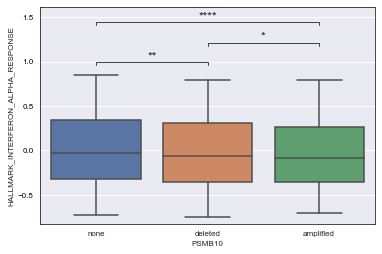

/home/rahul/miniconda3/envs/testenv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

none v.s. amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=1.332e-02 U_stat=7.143e+06
amplified v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=3.782e-01 U_stat=1.380e+06
none v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=1.279e-03 U_stat=4.940e+06


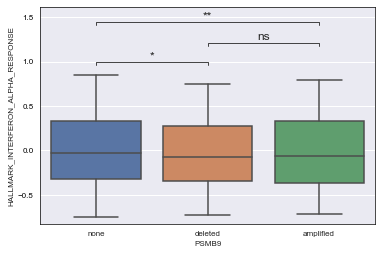

In [90]:
#sns.set(font_scale=1)
order=['none','deleted','amplified']
dft=copy_no_meth_jak_stat_gene_df[['PSMB10','HALLMARK_INTERFERON_ALPHA_RESPONSE']]
dft.loc[dft["PSMB10"] == 0,'PSMB10'] = 'none'
dft.loc[dft["PSMB10"] == 1,'PSMB10'] = 'amplified'
dft.loc[dft["PSMB10"] == 2,'PSMB10'] = 'amplified'
dft.loc[dft["PSMB10"] == -1,'PSMB10'] = 'deleted'
dft.loc[dft["PSMB10"] == -2,'PSMB10'] = 'deleted'
res=sns.boxplot(x="PSMB10", y="HALLMARK_INTERFERON_ALPHA_RESPONSE",data=dft,order=order)
add_stat_annotation(res, data=dft, x="PSMB10", y="HALLMARK_INTERFERON_ALPHA_RESPONSE",box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None,text_format='star', loc='inside', verbose=2,linewidth=0.9,fontsize = 12)
plt.savefig('/workspace/projects/immunoproteasome/plots/PSMB10_Interferon_plot.svg',bbox_inches = "tight",dpi=500)
plt.show()

dft=copy_no_meth_jak_stat_gene_df[['PSMB9','HALLMARK_INTERFERON_ALPHA_RESPONSE']]
dft.loc[dft["PSMB9"] == 0,'PSMB9'] = 'none'
dft.loc[dft["PSMB9"] == 1,'PSMB9'] = 'amplified'
dft.loc[dft["PSMB9"] == 2,'PSMB9'] = 'amplified'
dft.loc[dft["PSMB9"] == -1,'PSMB9'] = 'deleted'
dft.loc[dft["PSMB9"] == -2,'PSMB9'] = 'deleted'
res=sns.boxplot(x="PSMB9", y="HALLMARK_INTERFERON_ALPHA_RESPONSE",data=dft,order=order)
add_stat_annotation(res, data=dft, x="PSMB9", y="HALLMARK_INTERFERON_ALPHA_RESPONSE",box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None,text_format='star', loc='inside', verbose=2,linewidth=0.9,fontsize = 12)
plt.savefig('/workspace/projects/immunoproteasome/plots/PSMB9_Interferon_plot.svg',bbox_inches = "tight",dpi=500)
plt.show()

### IRF1 expression with copy number

In [91]:
import glob, os
os.chdir("/workspace/projects/immunoproteasome/data/tcga_tumor/")
list_of_tumor_filename=[]
for  i in glob.glob("*.tsv"):
    list_of_tumor_filename.append(i)
os.chdir("/workspace/incubator/rahul_project/")

In [92]:
input_path1="/workspace/projects/immunoproteasome/data/tcga_tumor/"
frames={}
for i in range(len(list_of_tumor_filename)):
    gene_data_frame=pd.read_csv(input_path1+list_of_tumor_filename[i],index_col='Hybridization REF',sep='\t')
    gene_data_frame.columns=gene_data_frame.columns.str.split('-').str[0:3].str.join('.')
    gene_data_frame=(gene_data_frame+1).T
    log_gene_data_frame=np.log2(gene_data_frame[['IRF1']])
    log_gene_data_frame=log_gene_data_frame.reset_index(level=0)
    frames[i]=log_gene_data_frame

IRF1_gene_expr=pd.concat(frames)
IRF1_gene_expr=IRF1_gene_expr.set_index(['index'])
copy_no_IRF1_gene_expr=pd.merge(copy_no_df.T[['PSMB8','PSMB9','PSMB10']], IRF1_gene_expr, left_index=True, right_index=True)

/home/rahul/miniconda3/envs/testenv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

none v.s. amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=7.315e-01 U_stat=3.505e+06
amplified v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=3.834e-05 U_stat=1.461e+06
none v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=8.625e-09 U_stat=6.241e+06


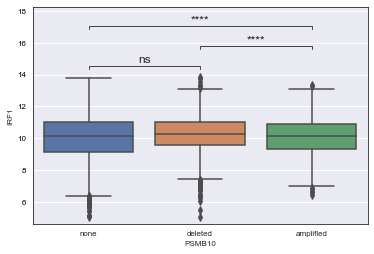

/home/rahul/miniconda3/envs/testenv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

none v.s. amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=1.424e-06 U_stat=5.315e+06
amplified v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=9.223e-01 U_stat=1.106e+06
none v.s. deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=4.795e-05 U_stat=3.426e+06


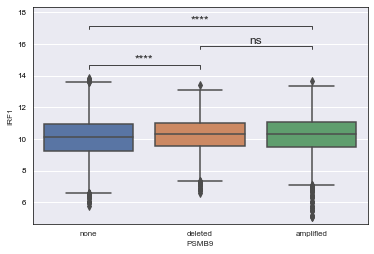

In [94]:
#sns.set(font_scale=1)
order=['none','deleted','amplified']
dft=copy_no_IRF1_gene_expr[['PSMB10','IRF1']]
dft.loc[dft["PSMB10"] == 0,'PSMB10'] = 'none'
dft.loc[dft["PSMB10"] == 1,'PSMB10'] = 'amplified'
dft.loc[dft["PSMB10"] == 2,'PSMB10'] = 'amplified'
dft.loc[dft["PSMB10"] == -1,'PSMB10'] = 'deleted'
dft.loc[dft["PSMB10"] == -2,'PSMB10'] = 'deleted'
res=sns.boxplot(x="PSMB10", y="IRF1",data=dft,order=order)
add_stat_annotation(res, data=dft, x="PSMB10", y="IRF1",box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None,text_format='star', loc='inside', verbose=2,linewidth=0.9,fontsize = 12)
plt.savefig('/workspace/projects/immunoproteasome/plots/PSMB10_IRF1_plot.svg',bbox_inches = "tight",dpi=500)
plt.show()

dft=copy_no_IRF1_gene_expr[['PSMB9','IRF1']]
dft.loc[dft["PSMB9"] == 0,'PSMB9'] = 'none'
dft.loc[dft["PSMB9"] == 1,'PSMB9'] = 'amplified'
dft.loc[dft["PSMB9"] == 2,'PSMB9'] = 'amplified'
dft.loc[dft["PSMB9"] == -1,'PSMB9'] = 'deleted'
dft.loc[dft["PSMB9"] == -2,'PSMB9'] = 'deleted'
res=sns.boxplot(x="PSMB9", y="IRF1",data=dft,order=order)
add_stat_annotation(res, data=dft, x="PSMB9", y="IRF1",box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None,text_format='star', loc='inside', verbose=2,linewidth=0.9,fontsize = 12)
plt.savefig('/workspace/projects/immunoproteasome/plots/PSMB9_IRF1_plot.svg',bbox_inches = "tight",dpi=500)
plt.show()